In [3]:
#load s140 datasets

In [17]:
import numpy as np

In [10]:
import os

In [16]:
import string

In [15]:
import pandas as pd

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [14]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

In [9]:
columns = ['Sentiment','Tweet_id','Date','Query','Username','Tweet']
df = pd.read_csv(r"s140_train.csv", names = columns, encoding="latin-1")
df = df.drop(['Tweet_id','Date','Query','Username'],axis =1)
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Sentiment  1600000 non-null  int64 
 1   Tweet      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [11]:
#take 5% data from the original dataset
s140_train = df.sample(frac = 0.05, random_state=1)

In [12]:
s140_train.groupby(by="Sentiment").sum()

,Tweet
Sentiment,
0,i miss nikki nu nu already shes always there ...
4,@macintom site doesn't seem to want to load up...


In [13]:
s140_test = pd.read_csv(r"s140_test.csv", names = columns)
s140_test = s140_test.drop(['Tweet_id','Date','Query','Username'],axis =1)
s140_test.head()

,Sentiment,Tweet
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


In [14]:
s140_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  498 non-null    int64 
 1   Tweet      498 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [15]:
s140_test.groupby(by="Sentiment").sum()

,Tweet
Sentiment,
0,Fuck this economy. I hate aig and their non lo...
2,Check this video out -- President Obama at the...
4,@stellargirl I loooooooovvvvvveee my Kindle2. ...


In [16]:
#load rtmr datasets

In [18]:
rtmr_training = pd.read_csv("rtmr_train.tsv",sep='\t')
rtmr_training.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,84400,4366,seen before from Murphy,2
1,45439,2208,exoticism,2
2,83575,4319,of the script,2
3,31453,1472,I had expected,2
4,79783,4111,"A standard police-oriented drama that , were i...",1


In [19]:
rtmr_training = rtmr_training.drop(['PhraseId','SentenceId'], axis =1)
rtmr_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148256 entries, 0 to 148255
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Phrase     148256 non-null  object
 1   Sentiment  148256 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [20]:
#group classes 1 and 3 so that the rtmr datasets will have same classed as s140 test dataset
rtmr_train = rtmr_training.replace([1,3], [0,4])

In [21]:
rtmr_train.groupby(by=["Sentiment"]).sum()

,Phrase
Sentiment,
0,"A standard police-oriented drama that , were i..."
2,seen before from Murphyexoticismof the scriptI...
4,is just such an achievementconceivablebe an ef...


In [22]:
rtmr_testing = pd.read_csv(r"rtmr_test.tsv",sep='\t')
rtmr_testing = rtmr_testing.drop(['PhraseId','SentenceId'], axis =1)
rtmr_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Phrase     7803 non-null   object
 1   Sentiment  7803 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 122.0+ KB


In [23]:
rtmr_test = rtmr_testing.replace([1,3], [0,4])

In [24]:
rtmr_test.groupby(by=["Sentiment"]).sum()

,Phrase
Sentiment,
0,"punched through by an inconsistent , meanderin..."
2,its depictionRobert DeNiro in Showtimea young ...
4,Despite modest aspirations its occasional char...


In [25]:
#delete text length less than 2 from training dataset
rtmr_train = rtmr_train[rtmr_train['Phrase'].map(lambda x: len(str(x)) >2)]

In [26]:
#count rows
count_row = rtmr_train.shape[0] 
print("Total reviews in dataframe:",count_row,"\n")

Total reviews in dataframe: 148065 



In [27]:
rtmr_train_texts = rtmr_train["Phrase"].tolist()
rtmr_train_sentiment = rtmr_train["Sentiment"].tolist()
print("RTMR Training phrases:",len(rtmr_train_texts))
print("RTMR Training sentiment labels:",len(rtmr_train_sentiment))

RTMR Training phrases: 148065
RTMR Training sentiment labels: 148065


In [28]:
rtmr_test_texts = rtmr_test["Phrase"].tolist()
rtmr_test_sentiment = rtmr_test["Sentiment"].tolist()
print("RTMR Test phrases:",len(rtmr_test_texts))
print("RTMR Test labels:",len(rtmr_test_sentiment))

RTMR Test phrases: 7803
RTMR Test labels: 7803


In [29]:
#tokenising rtmr datasets
import nltk

In [35]:
from nltk import word_tokenize 

In [36]:
#training set
rtmr_train_texts_tokenised = []
rtmr_train_sentiment_final = []
for i in range(len(rtmr_train_texts)):
    try:
        tokens = word_tokenize(rtmr_train_texts[i].lower()) 
        if(len(tokens)>1): 
            rtmr_train_texts_tokenised.append(tokens) 
            rtmr_train_sentiment_final.append(rtmr_train_sentiment[i]) 
    except:
        pass

In [37]:
print("text 1-6:", rtmr_train_texts_tokenised[0:5])
print("label 1-6:", rtmr_train_sentiment_final[0:5])

text 1-6: [['seen', 'before', 'from', 'murphy'], ['of', 'the', 'script'], ['i', 'had', 'expected'], ['a', 'standard', 'police-oriented', 'drama', 'that', ',', 'were', 'it', 'not', 'for', 'de', 'niro', "'s", 'participation', ',', 'would', 'have', 'likely', 'wound', 'up', 'a', 'tnt', 'original', '.'], ['the', 'title', 'performance', 'by', 'kieran', 'culkin']]
label 1-6: [2, 2, 2, 0, 2]


In [38]:
#testing set
rtmr_test_texts_tokenised = []
rtmr_test_sentiment_final = []
for i in range(len(rtmr_test_texts)):
    try:
        tokens = word_tokenize(rtmr_test_texts[i].lower()) 
        if(len(tokens)>1): 
            rtmr_test_texts_tokenised.append(tokens) 
            rtmr_test_sentiment_final.append(rtmr_test_sentiment[i]) 
    except:
        pass

In [39]:
#preprocessing on datasets
from nltk.corpus import stopwords
import re

In [40]:
stopwords_english = stopwords.words('english')

In [41]:
#preprocessing on training set
rtmr_train_texts_preprocessed = rtmr_train_texts_tokenised 
for i in range(len(rtmr_train_texts_tokenised)):
    new_tokens = []
    for word in rtmr_train_texts_tokenised[i]:
        word = word.replace("-","") 
        word = word.replace(".","") 
        regex_check = re.match("[a-z]+", word)
        if(regex_check!=None):
            if(regex_check.group()==word) and (word not in stopwords_english):
                    new_tokens.append(word)
    rtmr_train_texts_preprocessed[i] = new_tokens

In [42]:
print(rtmr_train_texts_preprocessed[0:10])

[['seen', 'murphy'], ['script'], ['expected'], ['standard', 'policeoriented', 'drama', 'de', 'niro', 'participation', 'would', 'likely', 'wound', 'tnt', 'original'], ['title', 'performance', 'kieran', 'culkin'], ['lack', 'idol', 'energy', 'passion', 'detail'], ['unfunny', 'lacking', 'sense', 'commitment', 'affection', 'characters', 'reginald', 'hudlin', 'comedy', 'relies', 'toilet', 'humor', 'ethnic', 'slurs'], ['situation'], ['achievement'], ['fans', 'adventues', 'steve', 'terri']]


In [43]:
emptyindex=[]
for i in range(len(rtmr_train_texts_preprocessed)):
    if(len(rtmr_train_texts_preprocessed[i])==0):
        #print("Input",i,"is empty!")
        emptyindex.append(i)

In [44]:
len(rtmr_train_texts_preprocessed)

132614

In [45]:
df1 = pd.DataFrame(list(zip(rtmr_train_texts_preprocessed,rtmr_train_sentiment_final)),columns =['Texts', 'Labels'])

In [46]:
rtmr_train_texts_df = df1.drop(emptyindex)

In [47]:
rtmr_train_texts_preprocessed = rtmr_train_texts_df['Texts'].values.tolist()
rtmr_train_sentiment_final = rtmr_train_texts_df['Labels'].values.tolist()

In [48]:
for i in range(len(rtmr_train_texts_preprocessed)):
    if(len(rtmr_train_texts_preprocessed[i])==0):
        print("Input",i,"is empty!")
        emptyindex.append(i)

In [49]:
len(rtmr_train_texts_preprocessed)

131508

In [50]:
#join strings in training list
rtmr_texts_train = []
for i in range(len(rtmr_train_texts_preprocessed)):
    text = " ".join(rtmr_train_texts_preprocessed[i])
    rtmr_texts_train.append(text)
print(rtmr_texts_train[0])

seen murphy


In [51]:
#join strings in testing list
rtmr_texts_test = []
for i in range(len(rtmr_test_texts_tokenised)):
    text = " ".join(rtmr_test_texts_tokenised[i])
    rtmr_texts_test.append(text)
print(rtmr_texts_test[0:5])

['despite modest aspirations its occasional charms are not to be dismissed .', 'its depiction', 'punched through by an inconsistent , meandering , and sometimes dry plot', 'robert deniro in showtime', "a young artist 's"]


In [52]:
rtmr_labels_train = rtmr_train_sentiment_final

In [53]:
rtmr_labels_test = rtmr_test_sentiment_final

In [54]:
#TF-IDF, naive bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [55]:
#first naive bayes model on rtmr datasets
model_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_nb.fit(rtmr_texts_train, rtmr_labels_train) 
predicted_categories_1 = model_nb.predict(rtmr_texts_test) # Predict the categories of the test data
print("Predicted:",predicted_categories_1.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",rtmr_labels_test[0:10]) # Print the first 10 ground truth values

Predicted: [4, 4, 0, 2, 2, 2, 2, 2, 4, 2]
Ground truth: [4, 2, 0, 2, 2, 2, 2, 4, 4, 2]


In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

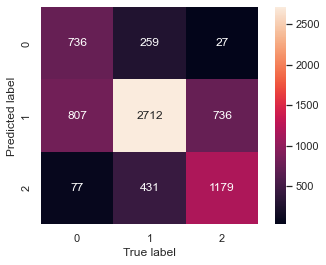

In [49]:
mat1 = confusion_matrix(rtmr_labels_test, predicted_categories_1)
sns.heatmap(mat1.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [50]:
print("Accuracy:\t%f" % accuracy_score(rtmr_labels_test, predicted_categories_1))
print("F1-score:\t%f" % f1_score(rtmr_labels_test, predicted_categories_1, average='macro'))
print("Precision:\t%f" % precision_score(rtmr_labels_test, predicted_categories_1, average='macro'))
print("Recall:\t\t%f" % recall_score(rtmr_labels_test, predicted_categories_1, average='macro'))
print("\nClassification performance:\n%s" % classification_report(rtmr_labels_test, predicted_categories_1))

Accuracy:	0.664417
F1-score:	0.638430
Precision:	0.685466
Recall:		0.619535

Classification performance:
              precision    recall  f1-score   support

           0       0.72      0.45      0.56      1620
           2       0.64      0.80      0.71      3402
           4       0.70      0.61      0.65      1942

    accuracy                           0.66      6964
   macro avg       0.69      0.62      0.64      6964
weighted avg       0.67      0.66      0.66      6964



In [51]:
#first naive bayes model s140 test dataset
s140_texts_test = s140_test["Tweet"].tolist()
s140_sentiment_test = s140_test["Sentiment"].tolist()
print("S140 Testing phrases:",len(s140_texts_test))
print("S140 Testing sentiment labels:",len(s140_sentiment_test))

S140 Testing phrases: 498
S140 Testing sentiment labels: 498


In [52]:
#tokenising s140_sentiment_test:
s140_test_texts_tokenised = []
s140_test_sentiment_final = []
for i in range(len(s140_texts_test)):
    try:
        tokens = word_tokenize(s140_texts_test[i].lower()) 
        if(len(tokens)>1): 
            s140_test_texts_tokenised.append(tokens) 
            s140_test_sentiment_final.append(s140_sentiment_test[i]) 
    except:
        pass

In [53]:
print("text 1-6:", s140_test_texts_tokenised[0:5])
print("label 1-6:", s140_test_sentiment_final[0:5])

text 1-6: [['@', 'stellargirl', 'i', 'loooooooovvvvvveee', 'my', 'kindle2', '.', 'not', 'that', 'the', 'dx', 'is', 'cool', ',', 'but', 'the', '2', 'is', 'fantastic', 'in', 'its', 'own', 'right', '.'], ['reading', 'my', 'kindle2', '...', 'love', 'it', '...', 'lee', 'childs', 'is', 'good', 'read', '.'], ['ok', ',', 'first', 'assesment', 'of', 'the', '#', 'kindle2', '...', 'it', 'fucking', 'rocks', '!', '!', '!'], ['@', 'kenburbary', 'you', "'ll", 'love', 'your', 'kindle2', '.', 'i', "'ve", 'had', 'mine', 'for', 'a', 'few', 'months', 'and', 'never', 'looked', 'back', '.', 'the', 'new', 'big', 'one', 'is', 'huge', '!', 'no', 'need', 'for', 'remorse', '!', ':', ')'], ['@', 'mikefish', 'fair', 'enough', '.', 'but', 'i', 'have', 'the', 'kindle2', 'and', 'i', 'think', 'it', "'s", 'perfect', ':', ')']]
label 1-6: [4, 4, 4, 4, 4]


In [54]:
s140_texts_test = []
for i in range(len(s140_test_texts_tokenised)):
    text = " ".join(s140_test_texts_tokenised[i])
    s140_texts_test.append(text)

In [55]:
s140_labels_test = s140_test_sentiment_final

In [56]:
#fitting model
predicted_categories_2 = model_nb.predict(s140_texts_test) 
print("Predicted:",predicted_categories_2.tolist()[0:10]) 
print("Ground truth:",s140_labels_test[0:10]) 

Predicted: [4, 2, 4, 2, 4, 4, 2, 4, 4, 2]
Ground truth: [4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


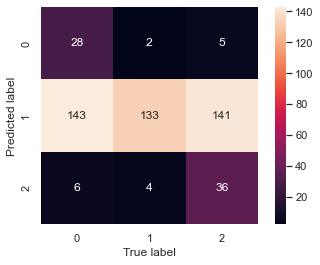

In [57]:
mat2 = confusion_matrix(s140_labels_test, predicted_categories_2)
sns.heatmap(mat2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [58]:
print("Accuracy:\t%f" % accuracy_score(s140_sentiment_test, predicted_categories_2))
print("F1-score:\t%f" % f1_score(s140_sentiment_test, predicted_categories_2, average='macro'))
print("Precision:\t%f" % precision_score(s140_sentiment_test, predicted_categories_2, average='macro'))
print("Recall:\t\t%f" % recall_score(s140_sentiment_test, predicted_categories_2, average='macro'))
print("\nClassification performance:\n%s" % classification_report(s140_sentiment_test, predicted_categories_2))

Accuracy:	0.395582
F1-score:	0.352786
Precision:	0.633851
Recall:		0.437610

Classification performance:
              precision    recall  f1-score   support

           0       0.80      0.16      0.26       177
           2       0.32      0.96      0.48       139
           4       0.78      0.20      0.32       182

    accuracy                           0.40       498
   macro avg       0.63      0.44      0.35       498
weighted avg       0.66      0.40      0.34       498



In [59]:
# start to tokenise s140 training set
s140_train = s140_train[s140_train['Tweet'].map(lambda x: len(str(x)) >2)]

In [60]:
#split the dataset
s140_train_texts = s140_train["Tweet"].tolist()
s140_train_sentiment = s140_train["Sentiment"].tolist()
print("S140 Training phrases:",len(s140_train_texts))
print("S140 Training sentiment labels:",len(s140_train_sentiment))

S140 Training phrases: 80000
S140 Training sentiment labels: 80000


In [61]:
#lowering texts in training set
s140_train_texts_tokenised = []
s140_train_sentiment_final = []
for i in range(len(rtmr_train_texts)):
    try:
        tokens = word_tokenize(s140_train_texts[i].lower()) 
        if(len(tokens)>1): 
            s140_train_texts_tokenised.append(tokens) 
            s140_train_sentiment_final.append(s140_train_sentiment[i]) 
    except:
        pass

In [62]:
print("text 1-6:", s140_train_texts_tokenised[0:5])
print("label 1-6:", s140_train_sentiment_final[0:5])

text 1-6: [['i', 'miss', 'nikki', 'nu', 'nu', 'already', 'shes', 'always', 'there', 'when', 'needed', 'thank', 'u', 'xxx'], ['so', 'i', 'had', 'a', 'dream', 'last', 'night', '.', 'i', 'remember', 'a', 'sign', 'which', 'clearly', 'told', 'me', 'where', 'to', 'get', 'a', 'job', '.', 'i', 'ca', "n't", 'rememer', 'what', 'the', 'sign', 'said', '.'], ['@', 'girlyghost', 'ohh', 'poor', 'sickly', 'you', '(', '(', '(', 'hugs', ')', ')', 'hope', 'you', 'feel', 'a', 'little', 'better', 'soon'], ['it', 'is', 'raining', 'again'], ['@', 'misskeribaby', 'wish', 'i', 'was', 'in', 'la', 'right', 'now']]
label 1-6: [0, 0, 0, 0, 0]


In [63]:
#preprocessing on training set
s140_train_texts_preprocessed = s140_train_texts_tokenised 
for i in range(len(s140_train_texts_tokenised)):
    new_tokens = []
    for word in s140_train_texts_tokenised[i]:
        word = word.replace("-","") 
        word = word.replace(".","") 
        regex_check = re.match("[a-z]+", word)
        if(regex_check!=None):
            if(regex_check.group()==word) and (word not in stopwords_english):
                    new_tokens.append(word)
    s140_train_texts_preprocessed[i] = new_tokens

In [64]:
print("text 1-6:", s140_train_texts_preprocessed[0:5])

text 1-6: [['miss', 'nikki', 'nu', 'nu', 'already', 'shes', 'always', 'needed', 'thank', 'u', 'xxx'], ['dream', 'last', 'night', 'remember', 'sign', 'clearly', 'told', 'get', 'job', 'ca', 'rememer', 'sign', 'said'], ['girlyghost', 'ohh', 'poor', 'sickly', 'hugs', 'hope', 'feel', 'little', 'better', 'soon'], ['raining'], ['misskeribaby', 'wish', 'la', 'right']]


In [65]:
len(s140_train_texts_preprocessed)

79913

In [66]:
len(s140_train_sentiment_final)

79913

In [67]:
emptyindex=[]
for i in range(len(s140_train_texts_preprocessed)):
    if(len(s140_train_texts_preprocessed[i])==0):
        #print("Input",i,"is empty!")
        emptyindex.append(i)
len(emptyindex)

106

In [68]:
df2 = pd.DataFrame(list(zip(s140_train_texts_preprocessed,s140_train_sentiment_final)))
s140_train_texts_df2 = df2.drop(emptyindex)

In [69]:
s140_train_texts_preprocessed = s140_train_texts_df2[0].values.tolist()
s140_train_sentiment_final = s140_train_texts_df2[1].values.tolist()

In [70]:
len(s140_train_texts_preprocessed)

79807

In [71]:
len(s140_train_sentiment_final)

79807

In [72]:
#join strings in training list
s140_texts_train = []
for i in range(len(s140_train_texts_preprocessed)):
    text = " ".join(s140_train_texts_preprocessed[i])
    s140_texts_train.append(text)
print(s140_texts_train[0])

miss nikki nu nu already shes always needed thank u xxx


In [73]:
# group test labels into binary classifications
s140_bi_labels_test = s140_labels_test
for i in range(len(s140_bi_labels_test)):
    if s140_bi_labels_test[i] == 2:
        s140_bi_labels_test[i] = 0

In [74]:
rtmr_bi_labels_test = rtmr_labels_test
for i in range(len(rtmr_bi_labels_test)):
    if rtmr_bi_labels_test[i] == 2:
        rtmr_bi_labels_test[i] = 0

In [75]:
import collections
counter=collections.Counter(s140_labels_test)
print(counter)

Counter({0: 316, 4: 182})


In [76]:
import collections
counter=collections.Counter(rtmr_labels_test)
print(counter)

Counter({0: 5022, 4: 1942})


In [77]:
s140_labels_train = s140_train_sentiment_final

In [78]:
#second naive bayes model trained on s140 training dataset
model_nb2 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_nb2.fit(s140_texts_train, s140_labels_train) 
#second naive bayes model tested on rtmr training dataset
predicted_categories_3 = model_nb2.predict(rtmr_texts_test) 
print("Predicted:",predicted_categories_3.tolist()[0:10]) 
print("Ground truth:",rtmr_bi_labels_test[0:10]) 

Predicted: [0, 4, 0, 0, 4, 4, 4, 0, 4, 4]
Ground truth: [4, 0, 0, 0, 0, 0, 0, 4, 4, 0]


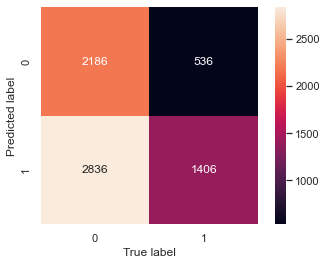

In [79]:
mat3 = confusion_matrix(rtmr_bi_labels_test, predicted_categories_3)
sns.heatmap(mat3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [80]:
print("Accuracy:\t%f" % accuracy_score(rtmr_bi_labels_test, predicted_categories_3))
print("F1-score:\t%f" % f1_score(rtmr_bi_labels_test, predicted_categories_3, average='macro'))
print("Precision:\t%f" % precision_score(rtmr_bi_labels_test, predicted_categories_3, average='macro'))
print("Recall:\t\t%f" % recall_score(rtmr_bi_labels_test, predicted_categories_3, average='macro'))
print("\nClassification performance:\n%s" % classification_report(rtmr_bi_labels_test, predicted_categories_3))

Accuracy:	0.515796
F1-score:	0.509644
Precision:	0.567267
Recall:		0.579640

Classification performance:
              precision    recall  f1-score   support

           0       0.80      0.44      0.56      5022
           4       0.33      0.72      0.45      1942

    accuracy                           0.52      6964
   macro avg       0.57      0.58      0.51      6964
weighted avg       0.67      0.52      0.53      6964



In [81]:
#second naive bayes model tested on s140 training dataset
predicted_categories_4 = model_nb2.predict(s140_texts_test) 
print("Predicted:",predicted_categories_4.tolist()[0:10]) 
print("Ground truth:",s140_bi_labels_test[0:10])

Predicted: [4, 4, 4, 0, 0, 4, 0, 4, 4, 4]
Ground truth: [4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


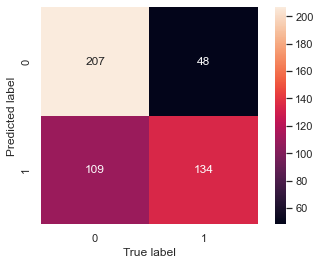

In [82]:
mat4 = confusion_matrix(s140_bi_labels_test, predicted_categories_4)
sns.heatmap(mat4.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [83]:
print("Accuracy:\t%f" % accuracy_score(s140_bi_labels_test, predicted_categories_4))
print("F1-score:\t%f" % f1_score(s140_bi_labels_test, predicted_categories_4, average='macro'))
print("Precision:\t%f" % precision_score(s140_bi_labels_test, predicted_categories_4, average='macro'))
print("Recall:\t\t%f" % recall_score(s140_bi_labels_test, predicted_categories_4, average='macro'))
print("\nClassification performance:\n%s" % classification_report(s140_bi_labels_test, predicted_categories_4))

Accuracy:	0.684739
F1-score:	0.677816
Precision:	0.681603
Recall:		0.695664

Classification performance:
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       316
           4       0.55      0.74      0.63       182

    accuracy                           0.68       498
   macro avg       0.68      0.70      0.68       498
weighted avg       0.72      0.68      0.69       498



In [84]:
import collections
counter=collections.Counter(rtmr_labels_train)
print(counter)

Counter({2: 62935, 4: 37990, 0: 30583})


In [85]:
rtmr_bi_labels_train = rtmr_labels_train
for i in range(len(rtmr_bi_labels_train)):
    if rtmr_bi_labels_train[i] == 2:
        rtmr_bi_labels_train[i] = 0

In [86]:
import collections
counter=collections.Counter(rtmr_bi_labels_train)
print(counter)

Counter({0: 93518, 4: 37990})


In [87]:
texts_train_set = rtmr_texts_train + s140_texts_train
labels_train_set = rtmr_bi_labels_train + s140_labels_train

In [88]:
len(texts_train_set)

211315

In [89]:
#third naive bayes model trained on rtmr + s140 training datasets
model_nb3 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_nb3.fit(texts_train_set, labels_train_set) 

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [90]:
#third naive bayes model tested on rtmr testing dataset
predicted_categories_5 = model_nb3.predict(rtmr_texts_test) 
print("Predicted:",predicted_categories_5.tolist()[0:10]) 
print("Ground truth:",rtmr_bi_labels_test[0:10]) 

Predicted: [0, 4, 0, 0, 0, 0, 0, 0, 4, 0]
Ground truth: [4, 0, 0, 0, 0, 0, 0, 4, 4, 0]


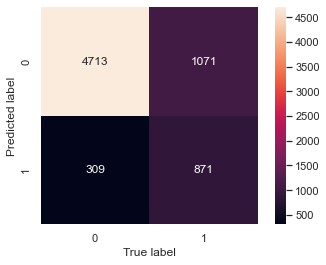

In [91]:
mat5 = confusion_matrix(rtmr_bi_labels_test, predicted_categories_5)
sns.heatmap(mat5.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [92]:
print("Accuracy:\t%f" % accuracy_score(rtmr_bi_labels_test, predicted_categories_5))
print("F1-score:\t%f" % f1_score(rtmr_bi_labels_test, predicted_categories_5, average='macro'))
print("Precision:\t%f" % precision_score(rtmr_bi_labels_test, predicted_categories_5, average='macro'))
print("Recall:\t\t%f" % recall_score(rtmr_bi_labels_test, predicted_categories_5, average='macro'))
print("\nClassification performance:\n%s" % classification_report(rtmr_bi_labels_test, predicted_categories_5))

Accuracy:	0.801838
F1-score:	0.715134
Precision:	0.776485
Recall:		0.693489

Classification performance:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      5022
           4       0.74      0.45      0.56      1942

    accuracy                           0.80      6964
   macro avg       0.78      0.69      0.72      6964
weighted avg       0.79      0.80      0.78      6964



In [93]:
#third naive bayes model tested on s140 testing dataset
predicted_categories_6 = model_nb3.predict(s140_texts_test) 
print("Predicted:",predicted_categories_6.tolist()[0:10]) 
print("Ground truth:",s140_bi_labels_test[0:10]) 

Predicted: [4, 4, 4, 0, 0, 4, 0, 4, 4, 0]
Ground truth: [4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


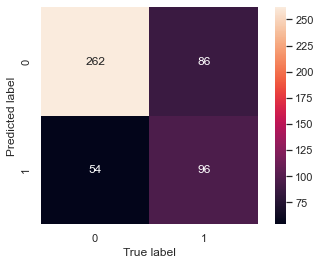

In [94]:
mat6 = confusion_matrix(s140_bi_labels_test, predicted_categories_6)
sns.heatmap(mat6.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [95]:
print("Accuracy:\t%f" % accuracy_score(s140_bi_labels_test, predicted_categories_6))
print("F1-score:\t%f" % f1_score(s140_bi_labels_test, predicted_categories_6, average='macro'))
print("Precision:\t%f" % precision_score(s140_bi_labels_test, predicted_categories_6, average='macro'))
print("Recall:\t\t%f" % recall_score(s140_bi_labels_test, predicted_categories_6, average='macro'))
print("\nClassification performance:\n%s" % classification_report(s140_bi_labels_test, predicted_categories_6))

Accuracy:	0.718876
F1-score:	0.683735
Precision:	0.696437
Recall:		0.678293

Classification performance:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       316
           4       0.64      0.53      0.58       182

    accuracy                           0.72       498
   macro avg       0.70      0.68      0.68       498
weighted avg       0.71      0.72      0.71       498



In [96]:
#CNN model for sentiment analysis
import torch

/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [97]:
import torch.nn as nn

In [98]:
df3 = pd.DataFrame(list(zip(rtmr_train_texts,rtmr_bi_labels_train)),columns =['Texts', 'Labels'])

In [99]:
df3.head()

,Texts,Labels
0,seen before from Murphy,0
1,exoticism,0
2,of the script,0
3,I had expected,0
4,"A standard police-oriented drama that , were i...",0


In [100]:
pos = []
neg = []
for l in df3.Labels:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 4:
        pos.append(1)
        neg.append(0)


In [101]:
df3['Pos']= pos
df3['Neg']= neg

In [102]:
df3.head()

,Texts,Labels,Pos,Neg
0,seen before from Murphy,0,0,1
1,exoticism,0,0,1
2,of the script,0,0,1
3,I had expected,0,0,1
4,"A standard police-oriented drama that , were i...",0,0,1


In [103]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

df3['Texts_Clean'] = df3['Texts'].apply(lambda x: remove_punct(x))

In [104]:
tokens = [word_tokenize(sen) for sen in df3.Texts_Clean] 

def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens] 

In [105]:
stopwords_english = stopwords.words('english')
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stopwords_english]

In [106]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 
df3['Tokens'] = filtered_words

In [107]:
df3['Texts_final'] = [' '.join(sen) for sen in filtered_words] 

In [108]:
df_cnn_train = df3[['Texts_final','Tokens','Labels','Pos','Neg']]

In [109]:
df_cnn_train.head()

,Texts_final,Tokens,Labels,Pos,Neg
0,seen murphy,"[seen, murphy]",0,0,1
1,exoticism,[exoticism],0,0,1
2,script,[script],0,0,1
3,expected,[expected],0,0,1
4,standard policeoriented drama de niro particip...,"[standard, policeoriented, drama, de, niro, pa...",0,0,1


In [110]:
all_training_words = [word for tokens in df_cnn_train["Tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in df_cnn_train["Tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

518440 words total, with a vocabulary size of 16270
Max sentence length is 30


In [67]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [64]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [111]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [58]:
from gensim import models

In [59]:
from gensim.models import Word2Vec

In [60]:
from gensim.models.keyedvectors import KeyedVectors

In [115]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/Users/liuyu/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [116]:
word2vec_path = path

In [61]:
word2vec = models.KeyedVectors.load_word2vec_format(path, binary=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/liuyu/.keras/datasets/news20.tar.gz'

In [118]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['Tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [119]:
training_embeddings = get_word2vec_embeddings(word2vec, df_cnn_train, generate_missing=True)

In [120]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [121]:
from keras.preprocessing.text import Tokenizer

In [122]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(df_cnn_train["Texts_final"].tolist())
training_sequences = tokenizer.texts_to_sequences(df_cnn_train["Texts_final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 16236 unique tokens.


In [123]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [124]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(16237, 300)


In [125]:
test_rtmr_sequences = tokenizer.texts_to_sequences(rtmr_texts_test)
test_rtmr_cnn_data = pad_sequences(test_rtmr_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [126]:
test_s140_sequences = tokenizer.texts_to_sequences(s140_texts_test)
test_s140_cnn_data = pad_sequences(test_s140_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [127]:
#define cnn model:

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [128]:
label_names = ['Pos', 'Neg']

In [129]:
y_train_val = df_cnn_train[label_names].values

In [130]:
x_train = train_cnn_data
y_train = y_train_val

In [131]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

2022-03-18 15:57:01.795024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      4871100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 49, 200)      120200      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 48, 200)      180200      embedding[0][0]                  
______________________________________________________________________________________________

In [150]:
num_epochs = 3
batch_size = 300

In [151]:
hist = model.fit(x_train, y_train, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/3
395/395 [==============================] - 736s 2s/step - loss: 0.5151 - acc: 0.7118 - val_loss: 0.7590 - val_acc: 0.6983
Epoch 2/3
395/395 [==============================] - 673s 2s/step - loss: 0.4937 - acc: 0.7288 - val_loss: 0.7938 - val_acc: 0.6673
Epoch 3/3
395/395 [==============================] - 706s 2s/step - loss: 0.4795 - acc: 0.7371 - val_loss: 0.8377 - val_acc: 0.6533


In [145]:
predict_cnn_1 = model.predict(test_rtmr_cnn_data, batch_size = 34, verbose = 1)

205/205 [==============================] - 20s 96ms/step


In [146]:
labels = [1, 0]

In [147]:
predict_cnn1_labels=[]
for p in predict_cnn_1:
    predict_cnn1_labels.append(labels[np.argmax(p)])

In [148]:
print("Predicted:",predict_cnn1_labels[0:10]) # Print the first 10 predictions
print("Ground truth:",rtmr_labels_test[0:10]) # Print the first 10 ground truth values

Predicted: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ground truth: [4, 0, 0, 0, 0, 0, 0, 4, 4, 0]


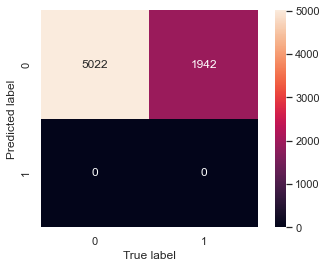

Accuracy:	0.721137
F1-score:	0.418989
Precision:	0.360569
Recall:		0.500000

Classification performance:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      5022
           4       0.00      0.00      0.00      1942

    accuracy                           0.72      6964
   macro avg       0.36      0.50      0.42      6964
weighted avg       0.52      0.72      0.60      6964



/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

In [149]:
mat = confusion_matrix(rtmr_labels_test, predict_cnn1_labels)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(rtmr_labels_test, predict_cnn1_labels))
print("F1-score:\t%f" % f1_score(rtmr_labels_test, predict_cnn1_labels, average='macro'))
print("Precision:\t%f" % precision_score(rtmr_labels_test, predict_cnn1_labels, average='macro'))
print("Recall:\t\t%f" % recall_score(rtmr_labels_test, predict_cnn1_labels, average='macro'))
print("\nClassification performance:\n%s" % classification_report(rtmr_labels_test, predict_cnn1_labels))

In [143]:
predict_cnn_2 = model.predict(test_s140_cnn_data, batch_size = 34, verbose = 1)

15/15 [==============================] - 1s 99ms/step


In [153]:
predict_cnn2_labels=[]
for p in predict_cnn_2:
    predict_cnn2_labels.append(labels[np.argmax(p)])

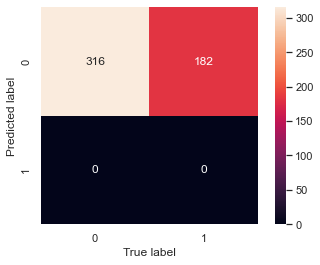

Accuracy:	0.721137
F1-score:	0.418989
Precision:	0.360569
Recall:		0.500000

Classification performance:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      5022
           4       0.00      0.00      0.00      1942

    accuracy                           0.72      6964
   macro avg       0.36      0.50      0.42      6964
weighted avg       0.52      0.72      0.60      6964



/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

In [154]:
mat = confusion_matrix(s140_labels_test, predict_cnn2_labels)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(rtmr_labels_test, predict_cnn1_labels))
print("F1-score:\t%f" % f1_score(rtmr_labels_test, predict_cnn1_labels, average='macro'))
print("Precision:\t%f" % precision_score(rtmr_labels_test, predict_cnn1_labels, average='macro'))
print("Recall:\t\t%f" % recall_score(rtmr_labels_test, predict_cnn1_labels, average='macro'))
print("\nClassification performance:\n%s" % classification_report(rtmr_labels_test, predict_cnn1_labels))

In [2]:
from torchtext import data

/Users/liuyu/opt/anaconda3/envs/py_3_9_7/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
!python -m spacy download en

In [1]:
conda install -c conda-forge spacy-model-en_core_web_sm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/liuyu/opt/anaconda3/envs/py_3_9_7

  added / updated specs:
    - spacy-model-en_core_web_sm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    spacy-model-en_core_web_sm-3.2.0|     pyhd8ed1ab_0        13.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        13.6 MB

The following NEW packages will be INSTALLED:

  spacy-model-en_co~ conda-forge/noarch::spacy-model-en_core_web_sm-3.2.0-pyhd8ed1ab_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2022.2.1-h~ --> conda-forge::c

Counter({0: 93518, 4: 37990})
